# Inference in Bayesian models: theory and practice

In this lesson we introduce some of the main models used in Bayesian inference, and we explore different approaches to inference in Bayesian methods.

## Binomial model

The binomial model is one of the most classical and important models in stastistical and Bayesian inference. 
It relates to a binary outcome that can take values $1$ or $0$. This kind of outcome arises from many type of observations around us (e.g. female or male, success or failure, diseased or healty, ...).

An important assumption behind the Binomial model, and many other models we'll see later, is about *exchangeability* of the obsevations. Basically, if we have a series of outcomes $y_1,y_2,\ldots,y_n$, we hypothesize that their value is independent from the order in which we observe them. This implies that the outcomes are independent, and the fact of observing a success for $y_k$ does not tell us anything about the outcome $y_{k+1}$, or $y_{k-1}$:

$$p(y_1,y_2,\ldots,y_n) = p(y_1)p(y_2)\ldots p(y_n)$$

In a Binomial model, the parameter $\theta$ indicates the probability of a sucess. Therefore, an observation will take value $1$ with probability $\theta$, and $0$, with probability $1-\theta$. For example, the probability of observing $n$ successes among $n$ observations will be 
\begin{align}
p(y_1 = 1, y_2 = 1,\ldots,y_n = 1|\theta) &= p(y_1 = 1|\theta)p(y_2 = 1|\theta)\ldots p(y_n =1|\theta) \\
&= \theta \theta\cdots \theta = \theta^n
\end{align}

In general, the binomial sampling model is 

$$ p(y|n, \theta) = {{n}\choose{y}} \theta^y(1-\theta)^{n-y} .$$

In what follows the constant $n$ is omitted. Recalling the Bayes theorem

$$ p( \theta | y) \propto  p( y|\theta) p(\theta),$$

we need to choose a proper prior model for $\theta$. In this first application, let's consider a uniform model $p(\theta) = U([0,1])$. In this kind of model, the pdf of $\theta$ is constant in the interval $[0,1]$. 
Therefore, the posterior for $\theta$ is as simple as:

$$ p(\theta|y) \propto \theta^y(1-\theta)^{n-y} .$$

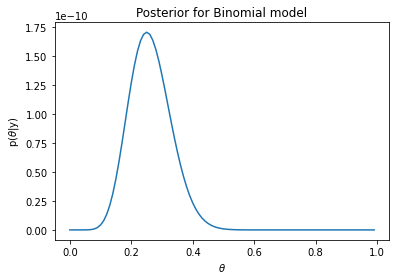

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
%matplotlib inline

theta = np.arange(0,1,.01)

n = 40
y = 10

post_theta = theta**y * (1-theta)**(n-y)
plt.plot(theta,post_theta)
plt.title('Posterior for Binomial model')
plt.ylabel(r'p($\theta$|y)')
plt.xlabel(r'$\theta$')
plt.show()

In [3]:
from scipy.special import comb
import plotly.graph_objects as go

post_theta_corrected = comb(n, y) * post_theta
go.Figure(
    data=[
        go.Line(x=theta, y=post_theta / post_theta.max()),
        go.Line(x=theta, y=post_theta_corrected / post_theta_corrected.max()),
    ]
)


/home/joris/.local/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(


## Beta distribution

The Beta distribution is a probability function importantly connected to the Binomial one.
It depends on two parameters, usually denoted by $\alpha$ and $\beta$, and takes the following form:

$$Beta(\theta|\alpha, \beta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)},$$

where the function at the denominator is again a normalizing constant called Beta function: $B(\alpha, \beta) = \int_\theta \theta^{\alpha-1}(1-\theta)^{\beta-1} d\theta$. The mean of the Beta distribution is $\mathbf{E}(Beta(\theta|\alpha, \beta)) = \frac{\alpha}{\alpha+\beta}$, and the variance is $Var(Beta(\theta|\alpha, \beta)) = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$.

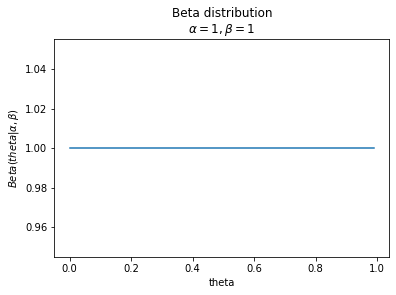

In [6]:
from scipy.special import beta as B

alpha = 1
beta = 1

Beta = theta**(alpha-1)*(1-theta)**(beta-1)/B(alpha, beta)

plt.plot(theta,Beta)
plt.title('Beta distribution''\n'r'$\alpha=$' + str(alpha) + r'$, \beta=$' + str(beta))
plt.ylabel(r'$Beta(theta|\alpha,\beta)$')
plt.xlabel('theta')
plt.show()



The link with the Binomial distribution can be already seen: the improper posterior of the Binomial parameter is proportional to a Beta with parameters $Beta(y+1, n-y+1)$.

Importantly, the Beta distribution provide us with an elegant way to  to specify a prior in Binomial models.
We note indeed that by multiplying a Binomial likelihood with a Beta prior, we obtain a Beta posterior: 

$$p(y|\theta) \propto \theta^y (1-\theta)^{n-y},$$
$$p(\theta) = Beta(\alpha,\beta) \propto \theta^{\alpha-1}(1-\theta)^{\beta-1},$$

then,

$$p(y|\theta)p(\theta) \propto \theta^{y+\alpha-1}(1-\theta)^{n+\beta-y-1} \propto Beta(\theta|\alpha+y,n+\beta-y)$$

This relationship is very important: when the posterior is of the same form of the prior, we say that the prior is *conjugate* of the likelihood. When the prior is conjugate, we can easily compute the posterior in a closed form.

**Exercise.** We observe 3 successes out of 10 tests. Our prior for the probaiblity of success is $Beta(8,2)$. Compute the posterior and evaluate the maximum of the posterior model.

In [98]:
n = 40
y = 10
prior_alpha = 8
prior_beta = 2

posterior_alpha = prior_alpha + y
posterior_beta = n + prior_beta - y

l = (
    theta ** (posterior_alpha - 1)
    * (1 - theta) ** (posterior_beta - 1)
    / B(y + prior_alpha, posterior_beta)
)
go.Figure(go.Line(x=theta, y=l))


/home/joris/.local/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Model inspection through sampling 

Once we derived the posterior we can study the solution by sampling from the associated probability model. In particular, knowing the parameters of the posterior, we are able to generate the family of $\theta$ parameters associated with it, and study the related properties and uncertainty. 

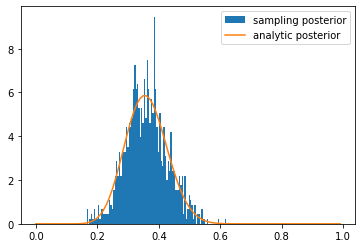

In [99]:
from scipy.stats import gaussian_kde
from scipy.stats import beta

# Compute posterior parameters
post_alpha = y + prior_alpha
post_beta = n + prior_beta - y

# Creating the posterior
posterior = beta(post_alpha, post_beta)

# Sampling from the posterior
post_sample = posterior.rvs(size=1000)

plt.hist(post_sample, bins=100, density=True, label="sampling posterior")
plt.plot(theta, posterior.pdf(theta), label="analytic posterior")
plt.legend()
plt.show()


**Exercise.** Compute  
- $0.2<p(\theta)<0.5$
- $0.6<p(\theta)<0.8$
- Mode, mean and variance of $\theta$


In [100]:
print(pd.Series(post_sample).between(0.2, 0.5).mean())
print(pd.Series(post_sample).between(0.6, 0.8).mean())
post_sample.mean(), post_sample.var(), post_sample.argmax() / len(post_sample)

0.961
0.001


(0.36016002067439434, 0.004742181905466921, 0.353)

## Applying the Bayes' rule via sampling 

Instead of deriving a closed form for the posterior, we can take a more practical approach to Bayesian inference by explicitly compute the posterior from simulation of the parameters. This is usually unpractical, but makes some sense in the Binomial case, as the model is very simple and low-dimensional (only one parameter). 

In practice we sample our parameters on a dense grid, and explicitly compute the associated posterior. This kind of approach is quite naive, and computationally expensive. Since we rely on uniform sampling from parameters' grid, this method scales geometrically with the number of parameters, and can easily turn to be computationally prohibitive when the number of parameters is too large, or the grid is too dense. 

However, this kind of approach provides a first example of *numerical approximation* of the posterior. 

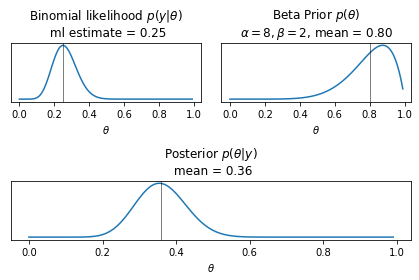

In [101]:
from scipy.stats import binom


# We compute the prior
prior_fun = beta(prior_alpha, prior_beta)
prior = prior_fun.pdf(theta)

## Estimating posterior 

# Uniform sampling of the parameter
theta = np.arange(0,1,0.01)

# We compute the data likelihood for each parameter value
likelihood = binom.pmf(y, n, theta) 

# We compute the posterior  
posterior = likelihood * prior 

plt.subplot(2, 2, 1)

plt.plot(theta,likelihood)
ml_est = np.argmax(likelihood)
plt.title(r'Binomial likelihood $p(y|\theta)$' + '\n ml estimate = {:.2f}'.format(theta[ml_est]))
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel(r'$\theta$')
plt.axvline(x = theta[ml_est], linewidth=0.5, color = 'black')

plt.subplot(2, 2, 2)

plt.plot(theta,prior_fun.pdf(theta))
mean = prior_fun.mean()
plt.title(r'Beta Prior $p(\theta)$' + '\n'r'$\alpha=$' + str(prior_alpha) + r'$, \beta=$' + str(prior_beta) + ', mean = {:.2f}'.format(mean))
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel(r'$\theta$')
plt.axvline(x = mean, linewidth=0.5, color = 'black')

plt.subplot(2, 1, 2)

plt.plot(theta,posterior)
mean = np.sum(theta*posterior)/np.sum(posterior)
plt.title(r'Posterior $p(\theta|y)$''\n mean = {:.2f}'.format(mean))
plt.gca().axes.get_yaxis().set_visible(False)
plt.axvline(x=mean, linewidth=0.5, color = 'black')
plt.xlabel(r'$\theta$')

plt.tight_layout()
plt.show()

We see that the results perfectly matches the theoretical results obtained earlier.
With this latter approach it is straightforward to replace prior (or likelihood) with any other form, independently from the underlying maths. 

**Exercise.** Replace the prior in the example before with a Uniform[0,1]  

**Exercise (from Gelman et al, Bayesian Data Analysis, Chapter 2).** An early study on *placenta previa*, a condition of pregnancy, found that on a sample of 980 births, 437 were females. How much evidence this data provide for the claim that the proportion of female births is below 0.485, the proportion of females in the general population?

In [102]:
from scipy.stats import beta


n = 980
y = 437

# We compute the posterior mean and quantiles for different sets of prior parameters

alpha_prior = [1, 5, 10, 50]
beta_prior = [1, 5, 10, 50]
pairs = [[ai, bi] for ai in alpha_prior for bi in beta_prior]
y/n

0.4459183673469388

# Gaussian model

Examples of Gaussian distributed data can be found everywhere, and in some sense the Gaussian distribution is a natural approximation for many phenomena obsevable in the realm of data analysis. This is the especially the case for measurements that *cumulate*, for example over multiple subjects or probes. This is formally stated by the central limit theorem.

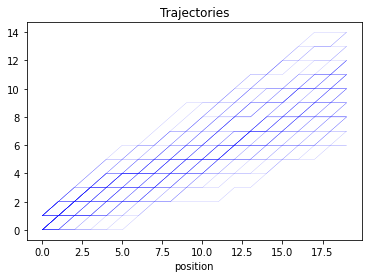

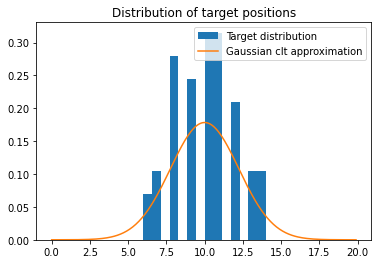

In [117]:
from scipy.stats import norm
from scipy.stats import bernoulli

path_length = 20
N_subjects = 50

prob_move = 0.5

sample = bernoulli.rvs(prob_move, size=path_length * N_subjects)
paths = np.cumsum(sample.reshape(N_subjects, path_length), 1)

[
    plt.plot(np.arange(path_length), paths[i, :], color="blue", lw=0.1)
    for i in range(N_subjects)
]
plt.title("Trajectories")
plt.xlabel("step")
plt.xlabel("position")
plt.show()


# Applying central limit theorem
bernoulli_mean = prob_move
bernoulli_var = prob_move * (1 - prob_move)

normal_clt_mean = path_length * bernoulli_mean
normal_clt_var = path_length * bernoulli_var

y = paths[:, path_length - 1]

plt.hist(y, bins=14, density=True, label="Target distribution")

x = np.arange(0, 20, 0.1)
plt.plot(
    x,
    norm.pdf(x, normal_clt_mean, np.sqrt(normal_clt_var)),
    label="Gaussian clt approximation",
)
plt.title("Distribution of target positions")
plt.legend()
plt.show()


To perform Bayesian inference in Gaussian models, we need to proceed similarly to the Binomial case. To obtain a posterior for the Gaussian parameters, the mean $\mu$ and variance $\sigma^2$, we need to specify the associated prior. 
In principle, any distribution can be used. In practice some choices are more popular, due to practical and theoretical reasons. We will see later how to work out the mathematics of the conjugate Gaussian model, in order to analytically derive a posterior for the Gaussian parameter. Before, analogously to what was shown in the binomial case, we develop an empyrical formalism for inference in Gaussian models through sampling.

The Gaussian (or Normal) distribution is parameterized by the mean $\theta$ and the variance $\sigma^2$. The likelihood takes the form:

$$ p(y|\mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma}\exp[{-\frac{1}{2\sigma^2}(y-\mu)^2}],$$

let's suppose that the variance $\sigma^2$ is known, and our goal is to estimate the posterior $p(\mu| y)$. As for the Binomial model, we should specify appropriate priors for the parameter $\mu$. We will see later that the privileged from for the prior of $\mu$ (i.e. the conjugate prior) is the Gaussian one, and we will work the math of it.

For the moment, let's not bother about maths, and simply make some assumptions and compute the posterior numerically. Let the prior be:

$$ p(\mu) = N(5, 4).$$


In [24]:
y_mean = np.mean(y)
y_var = 4

mean_prior_mu = 5
var_prior_mu = 4

prior_mu = norm(mean_prior_mu, np.sqrt(var_prior_mu))
#prior_var = uniform(loc = 0.4 , scale = 11)

# functions to compute log-likelihood and log-priors
def log_likelihood(param):
    return np.sum([norm.logpdf(point,param,np.sqrt(y_var)) for point in y])

def log_prior(param):
    return prior_mu.logpdf(param)

# Estimating posterior 
# Uniform sampling of the parameter
mu = np.linspace(0,20,200)

# We compute the (log-)likelihood and (log-)posterior for each value of the parameters
array_log_lik = np.array(list(map(log_likelihood, mu))).reshape(len(mu))
array_log_prior = np.array(list(map(log_prior, mu))).reshape(len(mu))

# We compute the (log-)posterior
array_log_posterior = array_log_prior + array_log_lik

# We identify the optimal parameter 
log_lik_optimum = (mu[np.argmax(array_log_lik)])
prior_optimum = (mu[np.argmax(array_log_prior)])
post_optimum = (mu[np.argmax(array_log_posterior)])

print('Likelihood optima:\n \u03BC = {:.2f}'.format(log_lik_optimum))

print('\nPrior optima:\n \u03BC = {:.2f}'.format(prior_optimum))

print('\nPosterior optima:\n \u03BC = {:.2f}'.format(post_optimum))

Likelihood optima:
 μ = 9.95

Prior optima:
 μ = 5.03

Posterior optima:
 μ = 9.45


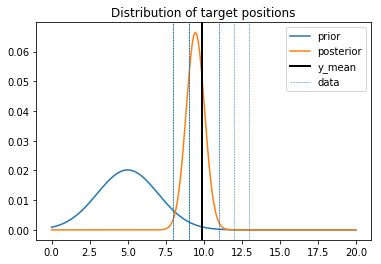

In [25]:
#Let's plot our distributions

x = np.arange(0,20,0.1)
plt.plot(mu, np.exp(array_log_prior)/np.sum(np.exp(array_log_prior)), label = 'prior')
plt.plot(mu, np.exp(array_log_posterior)/np.sum(np.exp(array_log_posterior)), label = 'posterior')
plt.axvline(y_mean, color = 'black', ls = '-', lw = 2, label= 'y_mean')
plt.title('Distribution of target positions')

[plt.axvline(sample, ls = '--', lw = 0.5) for sample in y]
plt.axvline(y[0], ls = '--', lw = 0.5, label= 'data')
plt.legend()
plt.show()

**Exercise.** Why the posterior is so close to the empirical mean? Play around with the prior parameters, the number of observatios, and explore their influence on the posterior. 

## A two-parameters example

Extending the sampling approach for the inference of $\mu$ and $\sigma^2$ is straightforward.
We first make a choice for the priors, for example:

$$ p(\mu) = N(5, 4),$$

$$p(\sigma^2) = N(2,1),$$

Then, we select a pair of candidate values $\mu_0, \sigma_0^2$ for mean and variance, and we evaluate the posterior 

$$p(\mu_0, \sigma_0^2|y) \sim p(y|\mu_0, \sigma_0^2)p(\mu_0 | 5, 4)p(\sigma_0^2|2, 1),$$

and we iterate the process for many different candidate samples $\mu_i$ and $\sigma_i^2$.

In [26]:
prior_mu_mean = 5
prior_mu_var = 4

prior_sigma_mean = 2
prior_sigma_var = 1

prior_mu = norm(prior_mu_mean, np.sqrt(prior_mu_var))
#prior_var = uniform(loc = 1 , scale = 15)
prior_var = norm(prior_sigma_mean, np.sqrt(prior_sigma_var))

Likelihood optima:
 μ = 9.80 
 σ2 = 2.65

Prior optima:
 μ = 4.90 
 σ2 = 1.92

Posterior optima:
 μ = 9.80 
 σ2 = 2.29


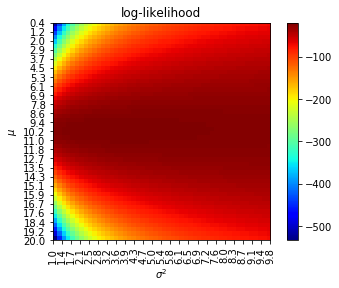

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


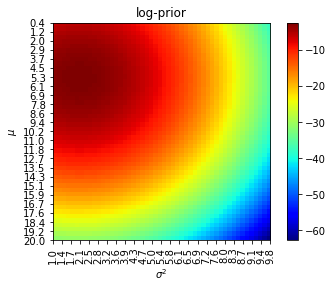

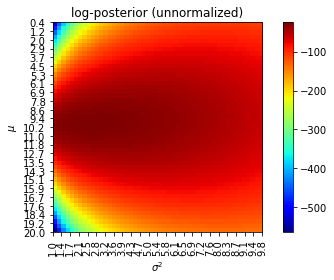

In [27]:
from itertools import product

# functions to compute log-likelihood and log-priors
def log_likelihood(params):
    # Assuming data exchangeability, we factorize the likelihood
    return np.sum([norm.logpdf(point,params[0],np.sqrt(params[1])) for point in y])

def log_prior(params):
    return prior_mu.logpdf(params[0])+ prior_var.logpdf(params[1])

# Estimating posterior 
# Uniform sampling parameters 
mu = np.linspace(0,20,50)
var = np.linspace(1,10,50)
# Creating a grid of parameters combinations
param_combinations = list(product(mu, var))

# We compute the (log-)likelihood and (log-)posterior for each combination of parameters
array_log_lik = np.array(list(map(log_likelihood, param_combinations))).reshape(len(mu),len(var))
array_log_prior = np.array(list(map(log_prior, param_combinations))).reshape(len(mu),len(var))

# We compute the unnormalized (log-)posterior
array_log_posterior = array_log_prior + array_log_lik 

# We identify the parameters' pair associated to the max of the posterior 
log_lik_optimum = (param_combinations[np.argmax(array_log_lik)])
prior_optimum = (param_combinations[np.argmax(array_log_prior)])
post_optimum = (param_combinations[np.argmax(array_log_posterior)])

print('Likelihood optima:\n \u03BC = {:.2f}'.format(log_lik_optimum[0]) 
      + ' \n \u03C32 = {:.2f}'.format(log_lik_optimum[1]) )

print('\nPrior optima:\n \u03BC = {:.2f}'.format(prior_optimum[0]) 
      + ' \n \u03C32 = {:.2f}'.format(prior_optimum[1]) )

print('\nPosterior optima:\n \u03BC = {:.2f}'.format(post_optimum[0]) 
      + ' \n \u03C32 = {:.2f}'.format(post_optimum[1]) )


ax0 = plt.gca()
img0 = ax0.imshow((array_log_lik), cmap='jet', interpolation='nearest', extent = [0,1,0,1])

ax0.set_xticks(np.linspace(0,1,int(len(var)/2)))
ax0.set_xticklabels([str(round(i,1)) for i in var[0::2]])
plt.xticks(rotation=90)

ax0.set_yticks(np.linspace(0,1,int(len(mu)/2)))
ax0.set_yticklabels([str(round(i,1)) for i in mu[::-1][0::2]])

plt.title('log-likelihood')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$\sigma^2$')
plt.colorbar(img0)
plt.show()


ax1 = plt.gca()
img1 = ax1.imshow((array_log_prior), cmap='jet', interpolation='nearest', extent = [0,1,0,1])

ax1.set_xticks(np.linspace(0,1,len(var)/2))
ax1.set_xticklabels([str(round(i,1)) for i in var[0::2]])
plt.xticks(rotation=90)

ax1.set_yticks(np.linspace(0,1,int(len(mu)/2)))
ax1.set_yticklabels([str(round(i,1)) for i in mu[::-1][0::2]])

plt.title('log-prior')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$\sigma^2$')
plt.colorbar(img1)
plt.show()


ax2 = plt.gca()
img2 = ax2.imshow(array_log_posterior, cmap='jet', interpolation='nearest', extent = [0,1,0,1])

ax2.set_xticks(np.linspace(0,1,int(len(var)/2)))
ax2.set_xticklabels([str(round(i,1)) for i in var[0::2]])
plt.xticks(rotation=90)

ax2.set_yticks(np.linspace(0,1,int(len(mu)/2)))
ax2.set_yticklabels([str(round(i,1)) for i in mu[::-1][0::2]])

plt.title('log-posterior (unnormalized)')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$\sigma^2$')
plt.colorbar(img2)

plt.tight_layout()

plt.show()


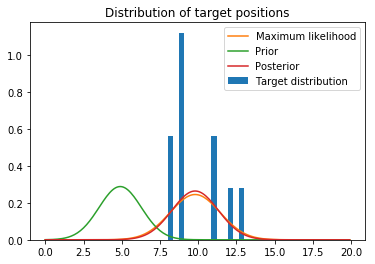

In [28]:
plt.hist(y, bins = 14, density = True, label = 'Target distribution')

x = np.arange(0,20,0.1)
plt.plot(x, norm.pdf(x, log_lik_optimum[0], np.sqrt(log_lik_optimum[1])), label = 'Maximum likelihood')
plt.plot(x, norm.pdf(x, prior_optimum[0], np.sqrt(prior_optimum[1])), label = 'Prior')
plt.plot(x, norm.pdf(x, post_optimum[0], np.sqrt(post_optimum[1])), label = 'Posterior')
plt.title('Distribution of target positions')
plt.legend()
plt.show()

## The maths guts of Bayesian inference in Gaussian models

The Gaussian (or Normal) distribution is parameterized by the mean $\theta$ and the variance $\sigma^2$. Assuming the variance $\sigma^2$ is known, the likelihood takes the form:

$$ p(y|\theta) = \frac{1}{\sqrt{2\pi}\sigma}\exp[{-\frac{1}{2\sigma^2}(y-\theta)^2}]$$

To proceed with our Bayesian reasoning, we need to specify a valid prior distribution for the Gaussian model. In this case, it turns out that the Gaussian distribution is still a valid conjugate prior. Let's prove this fact. Let's assume the prior to be Gaussian $p(\theta)= N(\mu_0, \tau_0^2)$, the posterior for the parameter is 

$$ p(\theta | y) = \frac{p(y|\theta)p(\theta)}{p(y)} .$$

Since the product of the numerator terms is

\begin{align}
p(y|\theta)p(\theta) &= \frac{1}{2\pi\sigma\tau_0}\exp[-\frac{1}{2\sigma^2}(y-\theta)^2 - \frac{1}{2\tau_0^2}(\theta-\mu_0)^2],
\end{align}

the variable of interest $\theta$ appears only in the argument of the exponential. Therefore we can focus only on this part, as all the rest is simply a normalization term:

\begin{align}
p(\theta | y) &\sim \exp[-\frac{1}{2\sigma^2}(y-\theta)^2 - \frac{1}{2\tau_0^2}(\theta-\mu_0)^2]\\
&= \exp\left( -\frac{ \tau_0^2 (y-\theta)^2 + \sigma^2(\theta-\mu_0)^2}{2\sigma^2 \tau_0^2} \right)\\
&= \exp\left( -\frac{ \tau_0^2 (y^2 - 2y\theta +\theta^2) + \sigma^2(\theta^2 -2\theta\mu_0 + \mu_0^2)}{2\sigma^2 \tau_0^2} \right)
\end{align}



We rearrange things to isolate the variable $\theta$:

\begin{align}
\exp\left( -\frac{ \tau_0^2 (y^2 - 2y\theta +\theta)^2 + \sigma^2(\theta^2 -2\theta\mu_0 + \mu_0^2)}{2\sigma^2  \tau_0^2} \right) &=  \exp\left( -\frac{ \theta^2 (\sigma^2 + \tau_0^2 ) -2 \theta (y \tau_0^2 + \mu_0\sigma^2) + \tau_0^2 y^2 + \sigma^2 \mu_0^2}{2\sigma^2  \tau_0^2} \right)\\
&= \exp\left( -\frac{1}{2}[\theta^2 \frac{(\sigma^2 + \tau_0^2 )}{\sigma^2 \tau_0^2} -2 \theta \frac{(y \tau_0^2 + \mu_0\sigma^2)}{\sigma^2 \tau_0^2} + \frac{\tau_0^2 y^2 + \sigma^2 \mu_0^2}{\sigma^2  \tau_0^2}] \right)\\
&=\exp\left( -\frac{1}{2} [\theta^2 (\frac{1}{\sigma^2} + \frac{1}{\tau_0^2 }) - 2 \theta ( \frac{y}{\sigma^2} + \frac{\mu_0}{\tau_0^2}) +  \frac{y^2 }{\sigma^2} +  \frac{\mu_0^2}{\tau_0^2} ]\right)\\
&= \exp\left( -\frac{1}{2} [l \theta^2  - 2 m \theta +  n]\right),
\end{align}

with

$$ l = \frac{1}{\sigma^2} + \frac{1}{\tau_0^2},$$

$$ m =  \frac{y}{\sigma^2} + \frac{\mu_0}{\tau_0^2},$$

and

$$ n = \frac{y^2 }{\sigma^2} +  \frac{\mu_0^2}{\tau_0^2}.$$ 


To identify that this quantity can be indeed related to a Gaussian distribution we need do a bit of more maths. 
In general, when we identify a quadratic form 

$$ l \theta^2 -2 m\theta + n,$$ 

this can be related to the square 

$$ A (\theta - B) ^2 + k,  $$

where $A = l$, $B = \frac{m}{l}$, and $k = n - AB^2$. Indeed we have:

\begin{align}
A (\theta - B) ^2 + k &= A \theta^2 - 2AB\theta + AB^2 + k \\
&= l\theta^2 - 2m\theta + \frac{m^2}{l} + n -  \frac{m^2}{l} = l\theta^2 - 2m\theta + n.
\end{align}

Our posterior can therefore be rewritten as:
\begin{align}
p(\theta|y)&\sim \exp\left(-\frac{1}{2} A (\theta - B)^2 +k  \right)\\
&= \exp\left(-\frac{1}{2} A (\theta - B)^2\right) \exp\left(k\right)\\
&\sim \exp\left(-\frac{1}{2} A (\theta - B)^2\right),
\end{align}
where, since the term in $k$ does not depend on $\theta$ is treated as a constant. 
We note that an exponential of this form corresponds to an un-normalized Gaussian distribution with mean $\mu_1 = B$, and standard deviation $\sigma_1^2 = \frac{1}{A}$.

In our case we thus obtain $p(\theta|y)\sim N(\mu_1,\sigma_1^2)$, with:

$$ \sigma_1^2 = \frac{1}{\frac{1}{\sigma^2} + \frac{1}{\tau_0^2}},$$

and

$$ \mu_1 = \frac{\frac{y}{\sigma^2} + \frac{\mu_0}{\tau_0^2}}{\frac{1}{\sigma^2} + \frac{1}{\tau_0^2}}.$$






This expression is of interest, as it tells us that the posterior mean is the weighted average between the observations $y$, and the posterior mean $\mu_0$. The weights are the precision associated to respectively data and prior. This is intuitive, as the more confident we are about our data, the higher the weight of the data term in the posterior distribution. 
At the extremes, when the precision of the data goes to infinity, $\frac{1}{\sigma^2}\to \infty$, the posterior mean is the data: $\mu_1 = y$. Equivalent conclusion for the precision of the prior: $\mu_1 = \mu_0$, for $\frac{1}{\tau_o^2}\to \infty$.

### Multiple Gaussian obervations

We now suppose to have multiple Gaussian distributed observations $\mathbf{y} = y_1, y_2, \ldots y_n$. Again, assuming exchangeability, we have: 

$$p(\mathbf{y}) = p(y_1, y_2, \ldots y_n) = p(y_1)p(y_2)\ldots p(y_n).$$

If $p(y_i) = N(\theta, \sigma^2)$

$$p(\mathbf{y}) = \frac{1}{(2\pi)^{\frac{n}{2}}\sigma^n}\exp(\frac{1}{2\sigma^2}\sum_{i=1}^n (y_i-\theta)^2).$$


As before, assuming a Gaussian prior distribution for $\theta$, $p(\theta) = N(\mu_0, \tau_0^2)$. Computing the prior, requires simply extending the computation made in the previous section, this time including the sum over the ultiple terms:

$$\sum_{i}(y_i-\theta)^2 = \sum_i y_i^2 - 2 \theta \sum_i y_i + n\theta^2.$$

It can straightforward to show that the posterior takes the form $p(\theta|y)\sim N(\mu_n,\sigma_n^2)$, with:


$$ \sigma_n^2 = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\tau_0^2}},$$

and,

$$ \mu_n = \frac{\frac{n \bar{y}}{\sigma^2} + \frac{\mu_0}{\tau_0^2}}{\frac{n}{\sigma^2} + \frac{1}{\tau_0^2}},$$


where $\bar{y} = \frac{\sum_{i=1}^{n}y_i}{n}$, is the average of the obsrevations.




**Exercise.** Given a prior $p(\theta) = N(5,2)$, compute the posterior distribution for the data of before:

# (next lesson) MAP: seeing the world from the tip of the mountain

In [31]:
from scipy.optimize import minimize


In [32]:
def evaluate_log_post(params, other_params, data, lik, priors):
  
    def f_to_minimize(params, other_params, data, lik, priors):
        model_list = { 'gaussian' : norm, 'uniform': uniform, 'binomial' : binom}
    
        model_lik = model_list[lik]
    
        log_prior = 0
        for i,mod in enumerate(priors):
            log_prior += model_list[mod[0]].logpdf(params[i], *mod[1])
        
        if len(other_params)>0:
            log_lik = np.sum([model_list[lik].logpdf(point, *(params,other_params)) for point in data])
        else:
            log_lik = np.sum([model_list[lik].logpdf(point, *(params)) for point in data])
        return - (log_lik + log_prior)
    
    minimum =  minimize(f_to_minimize, params,  args = (other_params, data, lik, priors), method = 'BFGS')
    print(minimum)
    return [minimum.x, minimum.hess_inv]

In [33]:
[map_solution, inv_hess] = evaluate_log_post([10,2], [], y, 'gaussian', [['gaussian',[4,np.sqrt(4)]], ['gaussian',[2,1]]])
#[map_solution, inv_hess] = evaluate_log_post([5,5], [], y, 'gaussian', [['gaussian',[18,np.sqrt(0.5)]], ['uniform',[1,15]]])

print(map_solution, inv_hess)

      fun: 25.78037665369375
 hess_inv: array([[ 0.28679152, -0.06227237],
       [-0.06227237,  0.15247085]])
      jac: array([-9.05990601e-06,  7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([9.48854344, 1.73165722])
[9.48854344 1.73165722] [[ 0.28679152 -0.06227237]
 [-0.06227237  0.15247085]]


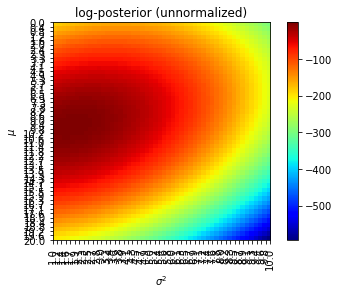

In [34]:
from scipy.stats import multivariate_normal
approx = multivariate_normal

mu = np.linspace(0,20,50)
var = np.linspace(1,10,50)

sol_space = np.ndarray([len(var),len(mu)])

for i,m in enumerate(mu):
    for j,v in enumerate(var):
        sol_space[i,j] = approx.logpdf([m,v], map_solution, (inv_hess))


ax = plt.gca()
img_map = ax.imshow(sol_space, cmap='jet', interpolation='nearest', extent = [0,1,0,1])        

#plt.imshow(sol_space)
plt.title('log-posterior (unnormalized)')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$\sigma^2$')

plt.colorbar(img_map)

ax.set_xticks(np.linspace(0,1,len(var)))
ax.set_xticklabels([str(round(i,1)) for i in var])
plt.xticks(rotation=90)

ax.set_yticks(np.linspace(0,1,len(mu)))
ax.set_yticklabels([str(round(i,1)) for i in mu[::-1]])

plt.show()


from scipy.stats import multivariate_normal

approx = multivariate_normal

      fun: 23.561311003104727
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([9.59123916])


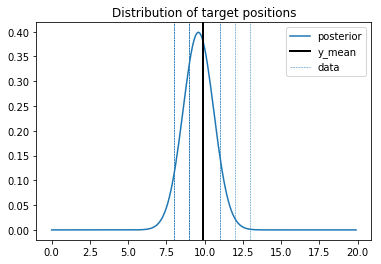

In [35]:
# Back to the example: posterior for the mean with fixed variance
[map_solution, inv_hess] = evaluate_log_post([10],  [np.sqrt(y_var)],  y, 'gaussian', [['gaussian',[5,np.sqrt(4)]]])

x = np.arange(0,20,0.1)
plt.plot(x, approx.pdf(x,map_solution, (inv_hess)), label = 'posterior')
plt.axvline(y_mean, color = 'black', ls = '-', lw = 2, label= 'y_mean')
plt.title('Distribution of target positions')

[plt.axvline(sample, ls = '--', lw = 0.5) for sample in y]
plt.axvline(y[0], ls = '--', lw = 0.5, label= 'data')
plt.legend()
plt.show()